# Deep Reinforcement Learning - Policy Gradient

## 1) RL background

* **Agent**: the one who is learning to win or get more rewards/ benefits.

* **Environment**: the world that the agent can interact with. The agent sees states and takes actions based on what he sees.

* **Reward**: the agent gets rewards or punishments based on his actions. We can think of low reward or negative reward as punishment. 

* **Policy**: the mindset of agent. The agent sees the current situation (state) and chooses an action. So the policy is a function of state, that outputs some actions:

 * action = f(state)

 We call the above f function, policy.


## 2) Policy Gradient method

Policy gradient is a method that trains the policy functions by gradients. Basically in each training, we push the policy to take good actions more bad actions less.

Here we use a Neural Network as policy and a Policy Gradient algorithm called REINFORCE.

Here follows how REINFORCE algorithm works:

* first initialize random parameters **θ**

* loop forever :

  1.   play and generate episode from start state using current policy -> **S<sub>0</sub>, A<sub>0</sub>, R<sub>1</sub>, S<sub>1</sub>, A<sub>1</sub>, R<sub>2</sub>, ..., S<sub>T-1</sub>, A<sub>T-1</sub>, R<sub>T</sub>**
  2.   loop for each timestep t=0, 1, ..., T-1. Compute reward from the timestep G. Update the policy parameters: **θ = θ + αG∇<sub>θ</sub>log(π)**

**π** is the probablity of taking the action that we took when playing.

**θ** are the Neural Network parameters in last layer. 

**G** is the reward from the state we are updating. 

**α** is the learning rate. 

**S0** is the initial state, **A0** is the action that agent selected after observing  S0, and **R1** is the reward given to the agent by the environment after taking action A0.
 
The agent continues to play until he wins or loses or the game ends at time T, and we save the states and actions and rewards for each state.

It is noticeable that the formula mentioned above is similar to Gradient Descent with **-log(π)** as loss: **θ=θ−αG∇<sub>θ</sub>(−log(π))**


The learning rate is multiplied by G, so if we get a high reward, we move much more in the direction of grad descent, while if we are punished and got a minus reward we move in opposite direction.

In the learning phase the policy outputs the probability of each action and we sample from that probability. In the playing phase we pick the most probable action or just sample like the training phase.

## 3) Preprocessing

In [1]:
import keras
import gym 
import numpy as np
import datetime

Using TensorFlow backend.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
env = gym.make('Pong-v0')
observation = env.reset()
observation.shape

(210, 160, 3)

Image of size 210*160 with 3 channels (rgb)

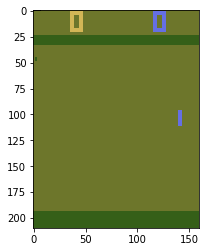

In [5]:
plt.imshow(observation)

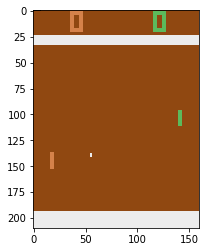

In [6]:
#take some steps to see middle game scene
for i in range(30):
    observation, reward, done, info = env.step(0) # 0 to not move, 2 to move paddle up, 3 to move paddle down 
plt.imshow(observation)

When the ball goes to end right, we get reward of -1 for losing, while if the ball crosses the opponent and reaches the left, we get a reward of +1. Game finishes if one of the players reach 21 score.

The definition of system in reinforcement learning method is simple:


*   state is the screen of game.
*   action is going up or down





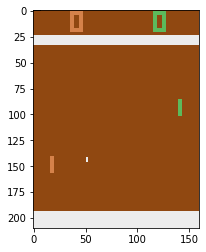

In [7]:
new_observation, reward, done, info = env.step(2)
plt.imshow(new_observation)

In order to use a neural network as policy, we need to convey enough information so it can learn where the ball is moving. In the above images, **it is not clear whether the ball is moving left or right**.
As simple solution to this problem, we **subtract two consecutive frames** and feed the resulting image to the network as input.

In [8]:
def preprocess_frames(new_frame,last_frame):
    # inputs are 2 numpy 2d arrays
    n_frame = new_frame.astype(np.int32)
    n_frame[(n_frame==144)|(n_frame==109)]=0 # remove backgound colors
    l_frame = last_frame.astype(np.int32)
    l_frame[(l_frame==144)|(l_frame==109)]=0 # remove backgound colors
    diff = n_frame - l_frame
    # crop top and bot 
    diff = diff[35:195]
    # down sample 
    diff=diff[::2,::2]
    # convert to grayscale
    diff = diff[:,:,0] * 299. / 1000 + diff[:,:,1] * 587. / 1000 + diff[:,:,2] * 114. / 1000
    
    # rescale numbers 
    max_val =diff.max() if diff.max()> abs(diff.min()) else abs(diff.min())
    if max_val != 0:
        diff=diff/max_val
    
    return diff

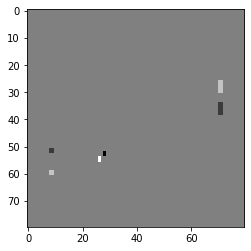

In [9]:
plt.imshow(preprocess_frames(new_observation,observation),plt.cm.gray)

Bottom and top of screen are cropped because they did not give any information, as well as the colours that are removed. Moreover, pixel values are rescaled between -1 and +1.

In [10]:
print(preprocess_frames(new_observation,observation).shape)
preprocess_frames(new_observation,observation)

(80, 80)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Image 80*80 derived by subtracting two consecutive frames, where most values are 0. Where paddles or ball have moved, it has non-zero values.

## 4) Model definition

We define a network with an architecture that inputs a 80*80 image and outputs the probability of going up.

In [11]:
# 2 layers model 
# 200 hidden units in first layer
# 1 sigmoid output
inputs = keras.layers.Input(shape=(80,80))
flattened_layer = keras.layers.Flatten()(inputs)
full_connected = keras.layers.Dense(units=200,activation='relu',use_bias=False,)(flattened_layer)
sigmoid_output = keras.layers.Dense(1,activation='sigmoid',use_bias=False)(full_connected)
policy_network_model = keras.models.Model(inputs=inputs,outputs=sigmoid_output)
policy_network_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________



## 5) Loss definition

keras loss function has format: def loss(y_true,y_pred): ... . 

Since we needed to include the reward in loss, we created m_loss function below as a tool to input episode_reward as input.

In [12]:
def m_loss(episode_reward):
    def loss(y_true,y_pred):
        # feed in y_true as actual action taken 
        # if actual action was up, we feed 1 as y_true and otherwise 0
        # y_pred is the network output(probablity of taking up action)
        # note that we dont feed y_pred to network. keras computes it.
        
        # we clip y_pred between some values because log(0) and log(1) are undefined
        tmp_pred = keras.layers.Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(y_pred)
        # we calculate log of probablity. y_pred is the probablity of taking up action.
        # note that y_true is 1 when we actually chose up, and 0 when we chose down.
        # this is similar to cross enthropy formula in keras, but here we write it manually to multiply it by the reward value
        tmp_loss = keras.layers.Lambda(lambda x:-y_true*keras.backend.log(x)-(1-y_true)*(keras.backend.log(1-x)))(tmp_pred)
        # multiply log of policy by reward
        policy_loss=keras.layers.Multiply()([tmp_loss,episode_reward])
        return policy_loss
    return loss

We create the optimizer and the network for training.

We input both rewards and the inputs(processed 80*80 image). The output of the network is the same.

Since both policy_network_train and policy_network_model (defined in previous section) use same layers (from inputs to outputs), they share their weights and parameters. So we just train using policy_network_train and then use policy_network_model when playing and simulating.

In [13]:
episode_reward = keras.layers.Input(shape=(1,),name='episode_reward')
policy_network_train = keras.models.Model(inputs=[inputs,episode_reward],outputs=sigmoid_output)
my_optimizer = keras.optimizers.RMSprop(lr=0.0001)
policy_network_train.compile(optimizer=my_optimizer,loss=m_loss(episode_reward),)

## 6) Episode generation

We define a function that takes a policy, plays according to the policy and keeps the rewards.

In [14]:
def generate_episode(policy_network):
    states_list = [] # shape = (x, 80, 80)
    up_or_down_action_list=[] # 1 if we chose up. 0 if down
    rewards_list=[]
    network_output_list=[]
    env=gym.make("Pong-v0")
    observation = env.reset()
    new_observation = observation
    done = False
    policy_output_list = []
    
    while done == False:
    
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        states_list.append(processed_network_input)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        network_output_list.append(up_probability)
        policy_output_list.append(up_probability)
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability]) # 2 is up. 3 is down 
        if actual_action==2:
            up_or_down_action_list.append(1)
        else:
            up_or_down_action_list.append(0)
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        
        rewards_list.append(reward)
        
        if done:
            break
            
    env.close()
    return states_list,up_or_down_action_list,rewards_list,network_output_list

Let's play a game and see what is the output.

In [15]:
states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)

In [16]:
print("length of states= "+str(len(states_list)))# this is the number of frames
print("shape of each state="+str(states_list[0].shape))
print("length of rewards= "+str(len(rewards_list)))

length of states= 1188
shape of each state=(80, 80)
length of rewards= 1188


In [17]:
# sample of policy output
print(network_output_list[30:50]) 

[0.5107068, 0.5110312, 0.5005014, 0.50189096, 0.52663267, 0.50009865, 0.50269914, 0.50019795, 0.4950057, 0.52642375, 0.4993386, 0.48787838, 0.5144545, 0.51750946, 0.49464855, 0.48362303, 0.49699566, 0.50043446, 0.49214283, 0.5264404]


Since the network is not trained, its output is about 50% all time, meaning that it does not know which action is better and outputs a probablity of about 0.5 for all states.

In [18]:
# sample of what the agent did: 1 means it went up, 0 means down
up_or_down_action_list[30:50]

[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]

In [19]:
# sample of rewards
print(rewards_list[50:100]) 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [20]:
# how many times we won through whole game:
print("count win="+str(len(list(filter(lambda r: r>0,rewards_list)))))
print("count lose="+str(len(list(filter(lambda r: r<0,rewards_list)))))
print("count zero rewards="+str(len(list(filter(lambda r: r==0,rewards_list)))))

count win=0
count lose=21
count zero rewards=1167


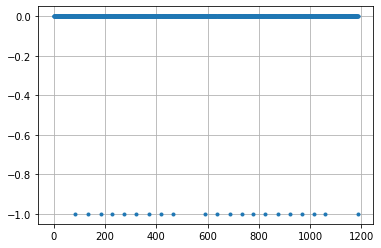

In [21]:
plt.plot(rewards_list,'.')
ax=plt.gca()
ax.grid(True)

If we train our network with this reward, it learns nothing
because the reward is most of the time zero: most gradients become zero because we multiply by reward in the above mentioned algorithm.

Notice now that only the action that we took to hit the ball was important to get the reward +1. Everything after hitting the ball was irrelevant to our win. A similar argument can be discussed about losing: the action near when we got score of -1 is more important than actions taken many steps earlier.

So we set the reward of actions taken before each reward, similar to the reward obtained.

For example if we got reward +1 at time 100, we say that reward of time 99 is +0.99, reward of time 98 is +0.98 and so on.

With this reward definition, we have the rewards for actions that actually resulted in a +1 or -1. and we assume the more recent the action to the reward gained, the more important it is.

In [22]:
def process_rewards(r_list):
    reward_decay=0.99
    tmp_r=0
    rew=np.zeros_like(r_list,dtype=np.float32)
    for i in range(len(r_list)-1,-1,-1):
        if r_list[i]==0:
            tmp_r=tmp_r*reward_decay
            rew[i]=tmp_r
        else: 
            tmp_r = r_list[i]
            rew[i]=tmp_r
    return rew

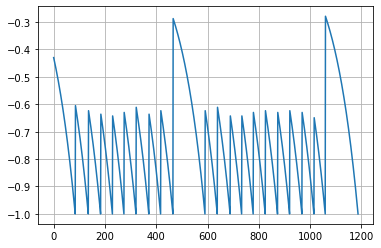

In [23]:
# this gives us:
plt.plot(process_rewards(rewards_list),'-')
ax=plt.gca()
ax.grid(True)

Now we rewrite the process_rewards function normalizing the rewards, subtracting by mean and dividing by std deviation.

In [24]:
def process_rewards(r_list):
    reward_decay=0.99
    tmp_r=0
    rew=np.zeros_like(r_list,dtype=np.float32)
    for i in range(len(r_list)-1,-1,-1):
        if r_list[i]==0:
            tmp_r=tmp_r*reward_decay
            rew[i]=tmp_r
        else: 
            tmp_r = r_list[i]
            rew[i]=tmp_r
    rew -= np.mean(rew) # subtract by average
    rew /= np.std(rew) # divide by std
    return rew

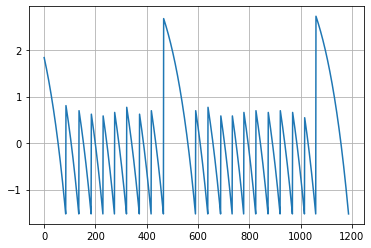

In [25]:
plt.plot(process_rewards(rewards_list),'-',)
ax=plt.gca()
ax.grid(True)

We got some positive scores in our new chart. This is because we subtracted by mean. Setting a positive score at the beginning of losing sequences could be justified by the fact that we approve actions where we catched the ball and did not get -1 reward immediately.

## 7) Training

We generate some episodes, then train on the batch. We also write a script to save the model in a file.

In [26]:
# we define a helper function to create a batch of simulations. After the batch simulations, we preprocess data and fit the network. 
def generate_episode_batches_and_train_network(n_batches=10):
    env = gym.make('Pong-v0')
    batch_state_list=[]
    batch_up_or_down_action_list=[]
    batch_rewards_list=[]
    batch_network_output_list=[]
    for i in range(n_batches):
        states_list,up_or_down_action_list,rewards_list,network_output_list = generate_episode(policy_network_model)   
        batch_state_list.extend(states_list[15:])
        batch_network_output_list.extend(network_output_list[15:])
        batch_up_or_down_action_list.extend(up_or_down_action_list[15:])
        batch_rewards_list.extend(rewards_list[15:])
    
    episode_reward=np.expand_dims(process_rewards(batch_rewards_list),1)
    x=np.array(batch_state_list)
    y_tmp = np.array(batch_up_or_down_action_list)
    y_true = np.expand_dims(y_tmp,1)
    policy_network_train.fit(x=[x,episode_reward],y=y_true)

    return batch_state_list,batch_up_or_down_action_list,batch_rewards_list,batch_network_output_list

In [28]:
train_n_times = 3500
for i in range(train_n_times):
    states_list,up_or_down_action_list,rewards_list,network_output_list=generate_episode_batches_and_train_network(10)
    if i%10==0:
        print("i="+str(i))
        rr=np.array(rewards_list)
        # i keeps how many times we won in batch
        print('count win='+str(len(rr[rr>0]))) 
        policy_network_model.save("policy_network_model_simple.h5")
        policy_network_model.save("policy_network_model_simple"+str(i)+".h5")
        with open('rews_model_simple.txt','a') as f_rew:
            f_rew.write("i="+str(i)+'       reward= '+str(len(rr[rr > 0])))
            f_rew.write("\n")

Epoch 1/1
13270/13270 [==============================] - 8s 618us/step - loss: 3.2655e-04
i=0
count win=6
Epoch 1/1
13869/13869 [==============================] - 9s 618us/step - loss: -1.4208e-04


KeyboardInterrupt: 

## 8) Playing

In [30]:
import time
def play_and_show_episode(policy_network):
    env = gym.make('Pong-v0')
    done=False
    observation = env.reset()
    new_observation = observation
    while done==False:
        time.sleep(1/80)
        
        processed_network_input = preprocess_frames(new_frame=new_observation,last_frame=observation)
        reshaped_input = np.expand_dims(processed_network_input,axis=0) # x shape is (80,80) so we need similar reshape(x,(1,80,80))

        up_probability = policy_network.predict(reshaped_input,batch_size=1)[0][0]
        actual_action = np.random.choice(a=[2,3],size=1,p=[up_probability,1-up_probability])
        
        env.render()
        
        observation= new_observation
        new_observation, reward, done, info = env.step(actual_action)
        if reward!=0:
            print(reward)
        if done:
            break
        
    env.close()

In [ ]:
play_and_show_episode(policy_network_model)

## 9) Load model from file

In [41]:
policy_network_model=keras.models.load_model("policy_network_model_simple170.h5")
policy_network_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


In [47]:
play_and_show_episode(policy_network_model)

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
1.0
-1.0
-1.0
-1.0
